<a href="https://colab.research.google.com/github/dogukartal/IBM_AI_Labs/blob/main/Generative%20AI%20Advance%20Fine-Tuning%20for%20LLMs/PPO_Trainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforcement Learning from Human Feedback Using PPO


----


## Setup


In [ ]:
!pip install --user datasets trl==0.11.0

In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import torch
from tqdm import tqdm
import pandas as pd

tqdm.pandas()

from transformers import pipeline, AutoTokenizer,AutoModelForCausalLM
from datasets import load_dataset

from trl import PPOTrainer, PPOConfig, AutoModelForCausalLMWithValueHead
from trl.core import LengthSampler
import os

import tarfile
import pickle
import json
import matplotlib.pyplot as plt
import torch
import pandas as pd
import warnings

warnings.filterwarnings('ignore')
# Disable warnings for a cleaner notebook or console experience
def warn(*args, **kwargs):
    pass
warnings.warn = warn

## Defining helper functions


In [2]:
# Helper Functions
def save_to_json(data, file_path):
    """
    Save a dictionary to a JSON file.

    Args:
        data (dict): The dictionary to save.
        file_path (str): The path to the JSON file.
    """
    with open(file_path, 'w') as json_file:
        json.dump(data, json_file, indent=4)
    print(f"Data successfully saved to {file_path}")


def load_from_json(file_path):
    """
    Load data from a JSON file.

    Args:
        file_path (str): The path to the JSON file.

    Returns:
        dict: The data loaded from the JSON file.
    """
    with open(file_path, 'r') as json_file:
        data = json.load(json_file)
    return data


In [3]:
def pad_sequence_to_length(tensor, length, pad_token_id):
    padding_length = length - tensor.size(0)
    if padding_length > 0:
        padding = torch.full((padding_length,), pad_token_id, dtype=torch.long, device=tensor.device)
        return torch.cat((tensor, padding))
    return tensor

def pad_list_to_batch_size(tensors, batch_size, pad_token_id):
    max_length = max(t.size(0) for t in tensors)
    padded_tensors = [pad_sequence_to_length(t, max_length, pad_token_id) for t in tensors]

    # Add additional padding-only tensors if needed
    while len(padded_tensors) < batch_size:
        padded_tensors.append(torch.full((max_length,), pad_token_id, dtype=torch.long, device=tensors[0].device))

    return padded_tensors[:batch_size]

In [4]:
def print_ppo_stats(stats, related_to_objective=False):
    print("PPO Training Statistics\n")

    if related_to_objective:
        print("Objective Statistics:")
        print(f"  KL Divergence (objective/kl): {stats['objective/kl']}")
        print(f"  KL Coefficient (objective/kl_coef): {stats['objective/kl_coef']}")
        print(f"  Entropy (objective/entropy): {stats['objective/entropy']}\n")

        print("PPO Losses (Related to Minimizing Objective Function):")
        print(f"  Policy Loss (ppo/loss/policy): {stats['ppo/loss/policy']}")
        print(f"  Value Loss (ppo/loss/value): {stats['ppo/loss/value']}")
        print(f"  Total Loss (ppo/loss/total): {stats['ppo/loss/total']}\n")

        print("PPO Policy Statistics:")
        print(f"  Policy Entropy (ppo/policy/entropy): {stats['ppo/policy/entropy']}")
        print(f"  Approx KL (ppo/policy/approxkl): {stats['ppo/policy/approxkl']}")
        print(f"  Clip Fraction (ppo/policy/clipfrac): {stats['ppo/policy/clipfrac']}\n")
    else:
        print("Reward and Value Function Estimation:")
        print(f"  Mean Non-Score Reward (ppo/mean_non_score_reward): {stats['ppo/mean_non_score_reward']}")
        print(f"  Mean Scores (ppo/mean_scores): {stats['ppo/mean_scores']}")
        print(f"  Std Scores (ppo/std_scores): {stats['ppo/std_scores']}")
        print(f"  Value Prediction (ppo/val/vpred): {stats['ppo/val/vpred']}")
        print(f"  Value Prediction Error (ppo/val/error): {stats['ppo/val/error']}")
        print(f"  Value Prediction Variance (ppo/val/var): {stats['ppo/val/var']}")
        print(f"  Value Prediction Mean (ppo/val/mean): {stats['ppo/val/mean']}")
        print(f"  Explained Variance (ppo/val/var_explained): {stats['ppo/val/var_explained']}\n")

    print("Token Lengths:")
    print(f"  Queries Length Mean (tokens/queries_len_mean): {stats['tokens/queries_len_mean']}")
    print(f"  Responses Length Mean (tokens/responses_len_mean): {stats['tokens/responses_len_mean']}\n")

    print("Time Statistics:")
    print(f"  Total Time (time/ppo/total): {stats['time/ppo/total']} seconds\n")

# Example usage with the provided stats and the flag

## Initializing the PPO Configuration, Model, And Tokenizer


In [5]:
# This class is for specifying the model and the learning rate of PPO training
config = PPOConfig(
    model_name="lvwerra/gpt2-imdb", # GPT-2 model fine-tuned on the IMDB dataset
    learning_rate=1.41e-5)

In [6]:
# Parameters for sentiment analysis pipeline
sent_kwargs = {"top_k":None, # All scores should be returned
               "function_to_apply": "none", # No function to apply
               "batch_size": 2 # Batch size
               }

In [7]:
# Load model and tokenizer
model_1 = AutoModelForCausalLMWithValueHead.from_pretrained(config.model_name)
tokenizer = AutoTokenizer.from_pretrained(config.model_name)
tokenizer.pad_token = tokenizer.eos_token # Padding token is set to EOS token

config.json:   0%|          | 0.00/577 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/548M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

In [8]:
# The reference model is used to stabilize the model using the Kullback-Leibler (KL) divergence between the current policy and the reference policy
# The KL divergence acts as a regularization term
model = AutoModelForCausalLMWithValueHead.from_pretrained(config.model_name)
ref_model = AutoModelForCausalLMWithValueHead.from_pretrained(config.model_name)

## Dataset and Dataset Tokenization
**Description:** The IMDB dataset is a collection of 50,000 movie reviews labeled as "positive" or "negative," indicating the sentiment of each review. This dataset is commonly used for sentiment analysis tasks.


In [9]:
dataset_name = "imdb"
ds = load_dataset(dataset_name, split = "train")

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [10]:
N = 5
for sample in range(N):
    print('text',ds[sample]['text'])
    print('label',ds[sample]['label'])

text I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between

In [11]:
# Rename the column "text" with "review"
ds = ds.rename_columns({"text": "review"})
# Filter the dataset to include only reviews that are longer than 200 characters
ds = ds.filter(lambda x: len(x["review"]) > 200, batched=False)
ds

Filter:   0%|          | 0/25000 [00:00<?, ? examples/s]

Dataset({
    features: ['review', 'label'],
    num_rows: 24895
})

In [12]:
# LengthSampler samples different Text Lengths during data processing so the model becomes more robust
input_min_text_length, input_max_text_length = 2, 8
input_size = LengthSampler(input_min_text_length, input_max_text_length)
input_size

In [13]:
# Sample Examples
for i in range(10):
    size=input_size()
    print(f"sample {i} has length {size}\n")

sample 0 has length 7

sample 1 has length 3

sample 2 has length 7

sample 3 has length 3

sample 4 has length 7

sample 5 has length 4

sample 6 has length 2

sample 7 has length 5

sample 8 has length 3

sample 9 has length 6



In [14]:
sample=ds[0]
sample

{'review': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far 

In [15]:
# Tokenize, truncate and assign
sample["input_ids"] = tokenizer.encode(sample["review"])[:input_size()]
sample["input_ids"]

[40, 26399, 314, 3001, 327, 47269]

In [16]:
# Decode and assign
sample["query"] = tokenizer.decode(sample["input_ids"])
sample["query"]

'I rented I AM CURI'

In [18]:
# Combine the Process
def tokenize(sample):
    sample["input_ids"] = tokenizer.encode(sample["review"])[: input_size()]
    sample["query"] = tokenizer.decode(sample["input_ids"])
    return sample

In [19]:
# Apply "tokenize" to the whole dataset using map method
ds = ds.map(tokenize, batched=False)
ds.set_format(type="torch")

Map:   0%|          | 0/24895 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1168 > 1024). Running this sequence through the model will result in indexing errors


In [20]:
ds[0]

{'review': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far 

In [22]:
# Print first 5 samples
for i, sample in enumerate(ds):
    if i >= 5:
        break
    print(f"Sample {i+1}:")
    print(f"Review: {sample['review']}")
    print(f"Input IDs: {sample['input_ids']}")
    print(f"Query: {sample['query']}")
    print("-" * 50)

Sample 1:
Review: I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few an

In [23]:
# Reinitiate the dataset
del(ds)
dataset_name="imdb"
ds = load_dataset(dataset_name, split="train")
ds = ds.rename_columns({"text": "review"})

In [24]:
def build_dataset(config, dataset_name="imdb", input_min_text_length=2, input_max_text_length=8,tokenizer=tokenizer):
    """
    Build dataset for training. This builds the dataset from `load_dataset`, one should
    customize this function to train the model on its own dataset.

    Args:
        dataset_name (`str`):
            The name of the dataset to be loaded.

    Returns:
        dataloader (`torch.utils.data.DataLoader`):
            The dataloader for the dataset.
    """

    tokenizer = AutoTokenizer.from_pretrained(config.model_name)
    tokenizer.pad_token = tokenizer.eos_token
    # load imdb with datasets
    ds = load_dataset(dataset_name, split="train")
    ds = ds.rename_columns({"text": "review"})
    ds = ds.filter(lambda x: len(x["review"]) > 200, batched=False)

    input_size = LengthSampler(input_min_text_length, input_max_text_length)

    def tokenize(sample):
        sample["input_ids"] = tokenizer.encode(sample["review"])[: input_size()]
        sample["query"] = tokenizer.decode(sample["input_ids"])
        return sample

    ds = ds.map(tokenize, batched=False)
    ds.set_format(type="torch")
    return ds

In [25]:
dataset = build_dataset(config)

Filter:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/24895 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1168 > 1024). Running this sequence through the model will result in indexing errors


In [26]:
dataset[0]

{'review': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far 

## Collator Function


In [27]:
def collator(data):
    return dict((key, [d[key] for d in data]) for key in data[0])

In [28]:
data = [
    {'input_ids': [1, 2, 3, 4], 'query': "sample text", 'review': "This is a sample review."},
    {'input_ids': [5, 6, 7, 8], 'query': "another sample", 'review': "Another sample review."}
]

In [29]:
batch = collator(data)
batch

{'input_ids': [[1, 2, 3, 4], [5, 6, 7, 8]],
 'query': ['sample text', 'another sample'],
 'review': ['This is a sample review.', 'Another sample review.']}

##  Initialize PPOTrainer

Proximal Policy Optimization (PPO) is a reinforcement learning algorithm that is particularly well-suited for training generative models, including those used for chatbots. It helps address specific challenges in training these models, such as maintaining coherent and contextually appropriate dialogues.

Proximal Policy Optimization (PPO) improves policy gradient methods for chatbots by using a clipped objective function, which ensures gradual and stable policy updates. This helps maintain consistent dialogue quality. Traditional policy gradient methods can lead to high variance and instability, resulting in inconsistent chatbot behavior. PPO's trust region balances exploring new responses and exploiting known good ones, making it more reliable for training chatbots.

The PPO Trainer collects dialogue samples, optimizes the chatbot's policy based on these samples, and manages the neural network models. This ensures stable and efficient training, leading to high-quality, coherent, and contextually appropriate chatbot responses.


```config``` : Configuration settings for PPO training, such as learning rate and model name

```model``` : The primary model to be fine-tuned using PPO

```tokenizer```:Tokenizer corresponding to the model, used for processing input text

```dataset```:  Dataset to be used for training, providing the input data for the model

```data_collator```: Data collator to handle batching and formatting of the input data


In [30]:
ppo_trainer = PPOTrainer(config, model, ref_model, tokenizer, dataset=dataset, data_collator=collator)
print("ppo_trainer object ",ppo_trainer)

ppo_trainer object  <trl.trainer.ppo_trainer.PPOTrainer object at 0x79190b0facd0>


In [31]:
device = ppo_trainer.accelerator.device
if ppo_trainer.accelerator.num_processes == 1:
    device = 0 if torch.cuda.is_available() else "cpu"
print(device)

0


## Reward function

In reinforcement learning with PPO (Proximal Policy Optimization), a reward function is used to provide feedback on the quality of the actions taken by the policy. For a generative model like a chatbot, the reward function can evaluate the quality of the generated responses. Here’s how the sentiment analysis pipeline can be used as a reward function:

In reinforcement learning with PPO, the sentiment analysis pipeline serves as a reward function to evaluate a chatbot's responses. By analyzing the sentiment of each response and assigning a reward based on the sentiment score, the PPO Trainer can optimize the chatbot’s policy to generate more positively received and engaging responses. This approach leverages sentiment analysis to provide meaningful feedback, guiding the chatbot towards improved performance in dialogue generation. Although not a typical reward model, it allows you to train the chatbot in a simple and effective way.


In [32]:
# Initialize the sentiment analysis pipeline
sentiment_pipe = pipeline("sentiment-analysis", model="lvwerra/distilbert-imdb", device=device)

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


In [33]:
text = "this movie was really bad!!"
sentiment_pipe(text, **sent_kwargs)

[{'label': 'NEGATIVE', 'score': 2.335048198699951},
 {'label': 'POSITIVE', 'score': -2.726576089859009}]

The `score` key represents the model's confidence in its prediction. Higher score values indicate greater confidence in the sentiment classification, such as "POSITIVE" or "NEGATIVE". Thus, the value for `POSITIVE` class can be used to determine the reward values. For example, a high score for "POSITIVE" means the model is confident, which can increase rewards. Conversely, if the model isn’t confident that a review is positive, it results in a negative reward, lowering the total reward. This means negative sentiment reviews decrease the overall reward, while positive ones increase it.


In [34]:
text = "this movie was really good!!"
sentiment_pipe(text, **sent_kwargs)

[{'label': 'POSITIVE', 'score': 2.557039976119995},
 {'label': 'NEGATIVE', 'score': -2.294790029525757}]

## Generating responses using PPO

### Tokenizing and preparing the input batch
This section of code demonstrates how to generate responses using the PPO (Proximal Policy Optimization) Trainer. The process involves tokenizing the input, preparing the batch for training, generating responses, and decoding the generated tokens into readable text.


The code first retrieves a batch of data from the PPO Trainer's dataloader and selects the first two entries for processing.


In [35]:
# Retrive a batch of data
batch = next(iter(ppo_trainer.dataloader))
batch.keys()

dict_keys(['label', 'input_ids', 'query'])

In [36]:
# Let's take the first two  sample in the batch
batch = {key: batch[key][0:2] for key in batch}
batch

{'label': [tensor(0, device='cuda:0'), tensor(0, device='cuda:0')],
 'input_ids': [tensor([19197,   645,  3241,   284,   262,  3651], device='cuda:0'),
  tensor([1212, 3807,  373, 7818,   13], device='cuda:0')],
 'query': ['Pay no attention to the comments', 'This movie was terrible.']}

In [38]:
# Initialize a list of response_tensors to store the responses for scoring
response_tensors = []

The below code extracts the `input_ids` from the `batch` and assigns them to `query_tensors`. These tensors represent the tokenized input sequences that will be used in the subsequent steps. They are called "query tensors" because they represent the initial input queries that will be processed by the model to generate responses.


In [39]:
query_tensors =  batch["input_ids"]
query_tensors

[tensor([19197,   645,  3241,   284,   262,  3651], device='cuda:0'),
 tensor([1212, 3807,  373, 7818,   13], device='cuda:0')]

The below code defines a lambda function `get_text` that takes a list of responses (`response`) and decodes each tensor in the list using the tokenizer, converting the tensor back to readable text. The `squeeze()` method is used to remove any dimensions of size 1 from the tensor.


In [40]:
get_text = lambda response:''.join([tokenizer.decode(r.squeeze()) for r in response])

You can see the original input queries in their text form.


In [41]:
get_text(query_tensors)

'Pay no attention to the commentsThis movie was terrible.'



The dictionary `generation_kwargs` sets the parameters for generating a sequence from the LLM (Language Model). The parameters include:
- `"min_length": -1` - No minimum length for the generated text.
- `"top_k": 0.0` - No filtering of the top-k most probable tokens.
- `"top_p": 1.0` - No nucleus sampling, using the entire distribution.
- `"do_sample": True` - Enables sampling, allowing for varied responses.
- `"pad_token_id": 50256` - ID of the padding token, ensuring uniform length across sequences.









In [42]:
generation_kwargs = {
    "min_length": -1,
    "top_k": 0.0,
    "top_p": 1.0,
    "do_sample": True,
    "pad_token_id": 50256,
}
generation_kwargs

{'min_length': -1,
 'top_k': 0.0,
 'top_p': 1.0,
 'do_sample': True,
 'pad_token_id': 50256}

The `output_length_sampler` is initialized with `LengthSampler(output_min_length, output_max_length)`. This object is used to sample output lengths for the generated sequences, ensuring they fall within the specified minimum and maximum length range. By varying the lengths, you can produce more diverse and natural outputs from the language model, preventing the generation of overly short or excessively long sequences and enhancing the overall quality of the responses.


In [43]:
output_min_length = 4
output_max_length = 16
output_length_sampler = LengthSampler(output_min_length, output_max_length)

The code calls the `output_length_sampler` to determine a length for the generated sequences. The sampled length is then stored in the variable `gen_len`.


In [44]:
gen_len = output_length_sampler()
gen_len

9

Next, set the `max_new_tokens` parameter in the `generation_kwargs` dictionary to the value of `gen_len`, which was sampled from `output_length_sampler`. This ensures that the maximum number of new tokens generated by the language model is within the desired length range, promoting more controlled and appropriately lengthened responses.


In [45]:
generation_kwargs["max_new_tokens"] = gen_len
generation_kwargs

{'min_length': -1,
 'top_k': 0.0,
 'top_p': 1.0,
 'do_sample': True,
 'pad_token_id': 50256,
 'max_new_tokens': 9}

Now, let's process one sample using PPO. Start by extracting the first query tensor.


In [46]:
query=query_tensors[0]
query

tensor([19197,   645,  3241,   284,   262,  3651], device='cuda:0')

Lets generate a response for the extracted query using the PPO trainer with the specified generation parameters (generation_kwargs). The generated response tensor is stored in ```response```.


In [47]:
response = ppo_trainer.generate(query, **generation_kwargs)
response

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


tensor([[19197,   645,  3241,   284,   262,  3651,    13, 24390,   606,  2644,
          1002,   379,   597,   640,   597]], device='cuda:0')

In [48]:
print("query:",get_text(query))
print("response:", get_text(response))

query: Pay no attention to the comments
response: Pay no attention to the comments. Avoid them ... If at any time any


Finally, append the tokens of the  ```response_tensors``` list. The ```squeeze()``` method removes any single-dimensional entries from the shape of the tensor, and the slicing``` [-gen_len:]``` ensures only the newly generated tokens are included, ignoring any preceding tokens.


In [49]:
response_tensors.append(response.squeeze()[-gen_len:])
print("newly generated tokens form response:", get_text(response_tensors[-gen_len:]))

newly generated tokens form response: . Avoid them ... If at any time any


Repeat the process for the second sample. This section generates a response for a given query, decodes the relevant part, and appends it to the `response_tensors` list.


In [50]:
query=query_tensors[1]
gen_len = output_length_sampler()
generation_kwargs["max_new_tokens"] = gen_len
response = ppo_trainer.generate(query, **generation_kwargs)
tokenizer.decode(response.squeeze()[-gen_len:], skip_special_tokens=True)
print("query:",get_text(query))
print("response ouput :", get_text(response_tensors))
response_tensors.append(response.squeeze()[-gen_len:])
print("newly generated tokens form response:", get_text(response_tensors[-gen_len:]))

query: This movie was terrible.
response ouput : . Avoid them ... If at any time any
newly generated tokens form response: . Avoid them ... If at any time any The building looked as


Convert each tensor in `response_tensors` into human-readable text and store it in the `batch` dictionary under the key `response`.


In [51]:
batch["response"] = [tokenizer.decode(r.squeeze()) for r in response_tensors]
batch["response"]

['. Avoid them ... If at any time any', ' The building looked as']

The batch now contains both `response` and `query` keys.


In [52]:
batch

{'label': [tensor(0, device='cuda:0'), tensor(0, device='cuda:0')],
 'input_ids': [tensor([19197,   645,  3241,   284,   262,  3651], device='cuda:0'),
  tensor([1212, 3807,  373, 7818,   13], device='cuda:0')],
 'query': ['Pay no attention to the comments', 'This movie was terrible.'],
 'response': ['. Avoid them ... If at any time any',
  ' The building looked as']}

### Scoring function

Next, prepare the text data for sentiment analysis, which can be a part of a reward function in a PPO setup where the sentiment analysis of interactions helps determine the reward.

Now, extract the `query` and `response` tensors and add them to the batch.


In [53]:
texts = [q + r for q, r in zip(batch["query"], batch["response"])]
texts

['Pay no attention to the comments. Avoid them ... If at any time any',
 'This movie was terrible. The building looked as']

The sentiment scores (`pipe_outputs`) can be used as feedback to update the policy


In [54]:
pipe_outputs = sentiment_pipe(texts, **sent_kwargs)
pipe_outputs

[[{'label': 'NEGATIVE', 'score': 1.7341057062149048},
  {'label': 'POSITIVE', 'score': -2.2238879203796387}],
 [{'label': 'NEGATIVE', 'score': 2.6016626358032227},
  {'label': 'POSITIVE', 'score': -2.9638869762420654}]]

These scores can be used to evaluate the quality or relevance of the generated responses, indicating the model's confidence in the likelihood of the responses being positive. The scores for the generated responses are extracted from the `pipe_outputs` list. Each element in `pipe_outputs` contains a list of scores corresponding to the model's output.


This line iterates over the `pipe_outputs` list, extracts the score from each output, converts it into a tensor, and stores it in the `rewards` list. The scores represent the model's confidence in the likelihood of the responses being positive sentences.


In [55]:
positive_scores = [
    item["score"]
    for output in pipe_outputs
    for item in output
    if item["label"] == "POSITIVE"
]
rewards = [torch.tensor(score) for score in positive_scores]
rewards

[tensor(-2.2239), tensor(-2.9639)]

### Proximal policy optimization

The training loop is responsible for performing a single update step of the PPO algorithm. The inputs to this process are the query, response, and score tensors.


In [56]:
print("query:", get_text(query_tensors))
print("\n")
print("response:", get_text(response_tensors))

query: Pay no attention to the commentsThis movie was terrible.


response: . Avoid them ... If at any time any The building looked as


To meet the PPO trainer's minimum batch size requirement of 128, you can pad the response tensors with additional sample.


In [57]:
batch_size=128
pad_token_id = tokenizer.pad_token_id

query_tensors = pad_list_to_batch_size(query_tensors, batch_size, pad_token_id)

response_tensors = pad_list_to_batch_size(response_tensors, batch_size, pad_token_id)
rewards=rewards+[torch.tensor(0) for _ in range(batch_size-len(rewards))]

Now, call the PPO `step` method that updates the model using the PPO algorithm with `query_tensors`, `response_tensors`, and `rewards`.

- It uses these inputs to calculate the policy and value function losses.
- It computes the gradients and updates the policy network parameters to improve the policy.
- It ensures that the policy update stays within a certain range to avoid large policy shifts, which is a core aspect of PPO.


In [ ]:
# stats = ppo_trainer.step(query_tensors, response_tensors, rewards)

The `stats` variable is a dictionary containing various statistics from the PPO training step. You can print out its keys using the function `print_ppo_stats`. These keys can be organized into two main categories:

- **Minimizing the language model loss**: `related_to_objective=True`
  - This includes statistics related to optimizing the model parameters, such as policy loss and value loss.

- **Calculating the reward**:
  - This involves metrics more relevant to reinforcement learning, such as advantage estimates and reward calculations.


In [ ]:
# stats.keys()

In [ ]:
# print_ppo_stats(stats, related_to_objective = True)

In [ ]:
# print_ppo_stats(stats)

In [ ]:
all_stats = []

The `sentiment`should be set to NEGATIVE for bad responses and POSITIVE for good responses score .


In [ ]:
sentiment = "POSITIVE"

<!-- ### Training Loop for PPO with Sentiment Analysis -->

This code snippet represents a training loop for the PPO (Proximal Policy Optimization) algorithm using sentiment analysis. The loop iterates over batches of data from the `ppo_trainer` dataloader and performs the following steps:

1. **Extract query tensors**:
    - The input IDs (query tensors) are extracted from the batch.

2. **Generate responses**:
    - For each query tensor, a response is generated using the `ppo_trainer.generate` method with the specified `generation_kwargs`.
    - The responses are then decoded and added to the batch under the `response` key.

3. **Compute sentiment scores**:
    - Text data is prepared by concatenating queries and responses.
    - Sentiment analysis is performed on the combined texts to compute the sentiment scores.
    - The scores are converted into tensors and stored in the `rewards` list.

4. **Run PPO step**:
    - The `ppo_trainer.step` method is called to update the model using the PPO algorithm with the `query_tensors`, `response_tensors`, and `rewards`.
    - This step calculates the policy and value function losses, computes gradients and updates the policy network parameters.
    - The policy update ensures it stays within a certain range to avoid large policy shifts.

5. **Logging statistics**:
    - The statistics from the PPO training step are logged and stored in the `all_stats` list.


In [ ]:
# for epoch, batch in tqdm(enumerate(ppo_trainer.dataloader)):
#     query_tensors = batch["input_ids"]
#     print(f"epoch {epoch}")

#     #### Get response from gpt2
#     response_tensors = []
#     for query in query_tensors:
#         gen_len = output_length_sampler()
#         generation_kwargs["max_new_tokens"] = gen_len
#         response = ppo_trainer.generate(query, **generation_kwargs)
#         response_tensors.append(response.squeeze()[-gen_len:])
#     batch["response"] = [tokenizer.decode(r.squeeze()) for r in response_tensors]

#     #### Compute sentiment score
#     texts = [q + r for q, r in zip(batch["query"], batch["response"])]
#     pipe_outputs = sentiment_pipe(texts, **sent_kwargs)
#     positive_scores = [
#            item["score"]
#            for output in pipe_outputs
#            for item in output
#            if item["label"] == sentiment
#        ]
#    rewards = [torch.tensor(score) for score in positive_scores]

#     #### Run PPO step
#     stats = ppo_trainer.step(query_tensors, response_tensors, rewards)
#     ppo_trainer.log_stats(stats, batch, rewards)

#     all_stats.append(stats)

In [ ]:
# # Save the model

# model_dir = "ppo-good"
# os.makedirs(model_dir, exist_ok=True)

# # Save model configuration and weights
# model_1.save_pretrained(model_dir)
# tokenizer.save_pretrained(model_dir)

In [58]:
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/gSWo8GeztngSmzHpqX_RaQ/ppo-good.pkl
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/we8t5N-45dVq3VhxGwYRAg/ppo-good-tar.gz

--2025-02-10 17:17:32--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/gSWo8GeztngSmzHpqX_RaQ/ppo-good.pkl
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21193579 (20M) [binary/octet-stream]
Saving to: ‘ppo-good.pkl’

ppo-good.pkl        100%[===================>]  20.21M  14.9MB/s    in 1.4s    

2025-02-10 17:17:34 (14.9 MB/s) - ‘ppo-good.pkl’ saved [21193579/21193579]

--2025-02-10 17:17:34--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/we8t5N-45dVq3VhxGwYRAg/ppo-good-tar.gz
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
C

In [59]:
# File name
file_name = "ppo-good-tar.gz"

# Open the tar.gz file
with tarfile.open(file_name, "r:gz") as tar:
    # Extract all the contents into the current directory
    tar.extractall()

print("Extraction completed.")

Extraction completed.


In [60]:
model_dir = "ppov3new1"
model_1 = AutoModelForCausalLMWithValueHead.from_pretrained(model_dir)
tokenizer = AutoTokenizer.from_pretrained(model_dir)

# Load training stats
file_name = "ppo-good.pkl"
with open(file_name, 'rb') as f:
    all_stats = pickle.load(f)

model_1.to(device)

Some weights of the model checkpoint at ppov3new1 were not used when initializing GPT2LMHeadModel: ['v_head.summary.bias', 'v_head.summary.weight']
- This IS expected if you are initializing GPT2LMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2LMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


AutoModelForCausalLMWithValueHead(
  (pretrained_model): GPT2LMHeadModel(
    (transformer): GPT2Model(
      (wte): Embedding(50257, 768)
      (wpe): Embedding(1024, 768)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0-11): 12 x GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2Attention(
            (c_attn): Conv1D(nf=2304, nx=768)
            (c_proj): Conv1D(nf=768, nx=768)
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Conv1D(nf=3072, nx=768)
            (c_proj): Conv1D(nf=768, nx=3072)
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (lm_head): Line

## Plotting PPO training loss and mean

1. **Extracting values**:
    - `loss_values`: Total loss values from `all_stats`.
    - `reward_values`: Mean reward values from `all_stats`.

2. **Plotting the loss**:
    - Line plot of total loss over epochs.

3. **Plotting the rewards**:
    - Line plot of mean reward over epochs.

4. **Displaying the plots**:
    - Arrange and show the plots using `plt.tight_layout()` and `plt.show()`.


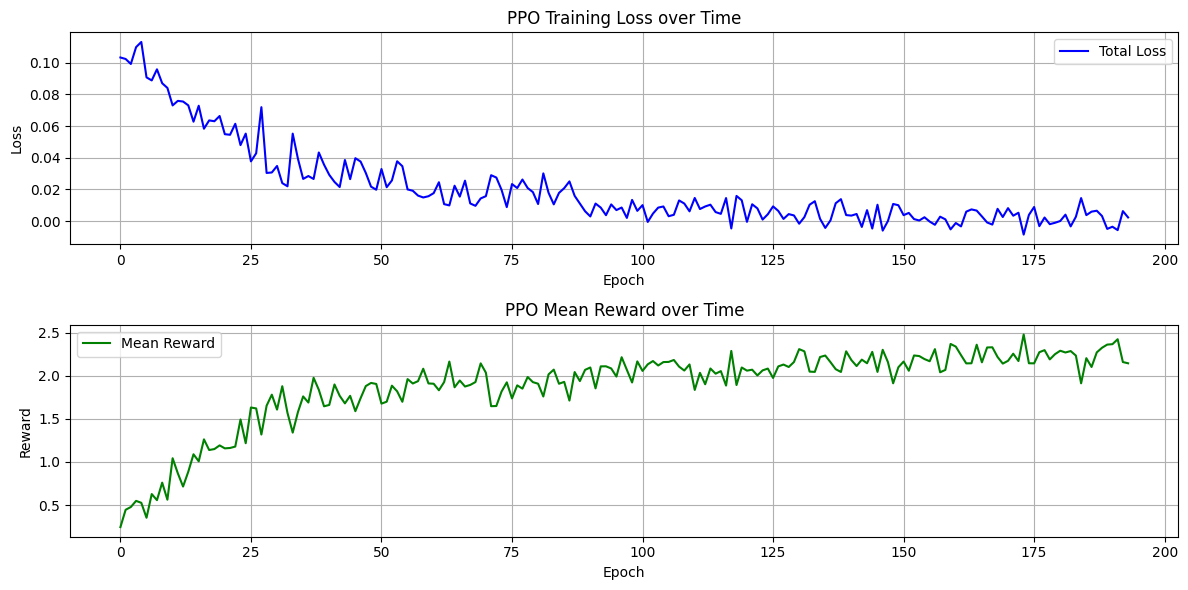

In [61]:
loss_values = [stat['ppo/loss/total'] for stat in all_stats]
reward_values = [stat['ppo/mean_scores'] for stat in all_stats]

# Plotting the loss
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(loss_values, label='Total Loss', color='b')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('PPO Training Loss over Time')
plt.legend()
plt.grid(True)

# Plotting the rewards
plt.subplot(2, 1, 2)
plt.plot(reward_values, label='Mean Reward', color='g')
plt.xlabel('Epoch')
plt.ylabel('Reward')
plt.title('PPO Mean Reward over Time')
plt.legend()
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()

## Generating and analyzing text with PPO and reference models


In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Set the pipeline device
pipeline_device = 0 if device.type == "cuda" else -1

**Text generation function**:
    - `generate_some_text(input_text, my_model)`: Tokenizes input text, generates a response, and decodes it.


In [63]:
gen_kwargs = {"min_length": -1, "max_new_tokens":20, "top_k": 0.0, "top_p": 1.0, "do_sample": True, "pad_token_id": tokenizer.eos_token_id}
def generate_some_text(input_text,my_model):
# Tokenize the input text
    input_ids = tokenizer(input_text, return_tensors='pt').input_ids.to(device)
    generated_ids = my_model.generate(input_ids,**gen_kwargs )

    # Decode the generated text
    generated_text_ = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    return generated_text_

**Generate text with PPO model**:
    - Generate text using the PPO-trained model.


In [64]:
input_text = "Once upon a time in a land far"

generated_text=generate_some_text(input_text,model_1)
generated_text

'Once upon a time in a land far beyond our own television, together we breath new life into a wonderful storytelling that celebrates the power of storytelling'

**Sentiment Analysis**:
    - Analyze the sentiment of the generated text using `sentiment_pipe`.


In [65]:
pipe_outputs = sentiment_pipe(generated_text, **sent_kwargs)
pipe_outputs

[{'label': 'POSITIVE', 'score': 2.852431535720825},
 {'label': 'NEGATIVE', 'score': -2.596557855606079}]

**Generate text with reference model**:
    - Generate text using the reference model.


In [66]:
generated_text = generate_some_text(input_text,ref_model)
generated_text

'Once upon a time in a land far from earth.Just standing inside the walls the hooded stranger of a building,in custody of the'

## Comparing PPO and reference models on

1. **Generation Parameters**:
    - Define `gen_kwargs` for text generation.

2. **Prepare Batch**:
    - Sample a batch of size `bs` from the dataset and extract query tensors.

3. **Generate Responses**:
    - For each query tensor, generate responses using both the reference model and the PPO model.

4. **Decode Responses**:
    - Decode the generated response tensors into human-readable text.

5. **Compute Sentiment Scores**:
    - Prepare texts by concatenating queries and responses.
    - Compute sentiment scores for the responses before and after training using `sentiment_pipe`.

6. **Store Results**:
    - Store queries, responses, and sentiment scores in `game_data`.
    - Convert `game_data` into a DataFrame and return it.


In [67]:
def compare_models_on_dataset(model, ref_model, dataset, tokenizer, sentiment_pipe, sent_kwargs, device, output_length_sampler):
    gen_kwargs = {
        "min_length": -1,
        "top_k": 0.0,
        "top_p": 1.0,
        "do_sample": True,
        "pad_token_id": tokenizer.eos_token_id
    }

    bs = 16
    game_data = dict()
    dataset.set_format("pandas")
    df_batch = dataset[:].sample(bs)
    game_data["query"] = df_batch["query"].tolist()
    query_tensors = df_batch["input_ids"].tolist()

    response_tensors_ref, response_tensors = [], []

    # Get maximum position embeddings for both models
    max_position_embeddings_ref = ref_model.config.max_position_embeddings
    max_position_embeddings_model = model.config.max_position_embeddings

    for i in range(bs):
        gen_len = output_length_sampler()

        # Convert query tensors to input IDs
        input_ids = torch.tensor(query_tensors[i]).unsqueeze(dim=0).to(device)

        # ********** Process for ref_model **********
        total_length_ref = input_ids.shape[-1] + gen_len
        if total_length_ref > max_position_embeddings_ref:
            # Truncate input_ids to fit within the max length
            max_input_length_ref = max_position_embeddings_ref - gen_len
            input_ids_ref = input_ids[:, -max_input_length_ref:]
            total_length_ref = input_ids_ref.shape[-1] + gen_len
        else:
            input_ids_ref = input_ids

        output = ref_model.generate(
            torch.tensor(query_tensors[i]).unsqueeze(dim=0).to(device),
            max_new_tokens=gen_len,
            **gen_kwargs
        ).squeeze()[-gen_len:]
        response_tensors_ref.append(output)

        # ********** Process for model **********
        total_length_model = input_ids.shape[-1] + gen_len
        if total_length_model > max_position_embeddings_model:
            max_input_length_model = max_position_embeddings_model - gen_len
            input_ids_model = input_ids[:, -max_input_length_model:]
            total_length_model = input_ids_model.shape[-1] + gen_len
        else:
            input_ids_model = input_ids

        output = model.generate(
            torch.tensor(query_tensors[i]).unsqueeze(dim=0).to(device),
            max_new_tokens=gen_len,
            **gen_kwargs
        ).squeeze()[-gen_len:]
        response_tensors.append(output)

    game_data["response (before)"] = [tokenizer.decode(response_tensors_ref[i]) for i in range(bs)]
    game_data["response (after)"] = [tokenizer.decode(response_tensors[i]) for i in range(bs)]

    texts_before = [q + r for q, r in zip(game_data["query"], game_data["response (before)"])]
    game_data["rewards (before)"] = [output[1]["score"] for output in sentiment_pipe(texts_before, **sent_kwargs)]

    texts_after = [q + r for q, r in zip(game_data["query"], game_data["response (after)"])]
    game_data["rewards (after)"] = [output[1]["score"] for output in sentiment_pipe(texts_after, **sent_kwargs)]

    df_results = pd.DataFrame(game_data)
    return df_results

In [68]:
df_results = compare_models_on_dataset(model_1, ref_model, dataset, tokenizer, sentiment_pipe, sent_kwargs, device, output_length_sampler)
df_results

,query,response (before),response (after),rewards (before),rewards (after)
0,The movie deserves 2/10,"from me, but two problems!!! The first one is...",...for all of it's amazing style and talent. T...,-0.420624,-2.311016
1,To say,"...it was not not a bad movie, and was",that I was thrilled as I saw first hand Here's,-1.563654,-1.734683
2,Why Panic never got a good,laugh 'cause its just kind,film!!! It was great!,-0.568586,-2.226753
3,Given the title and outlandish,plot lines and somewhat more-then-obsessively...,"plot, it's a great film. Every scene is exqui...",-2.795388,-2.543203
4,This is just the,"beginning, but I hope to see more films about...",best! I also think this film is great; it has...,-1.046235,-2.535839
5,As a,teacher of war literature serve,"great silent film, it",-0.605281,-2.064549
6,A very ordinary made-for,-TV film shot in the mountains. It is quite,"-TV movie of a famous documentary. Good suspense,",-1.107387,-1.772206
7,Not on the same,level. Far too,"level, it was",-1.604228,-1.036116
8,This is not a bad film,.Thats why you,- it is brilliant!,-0.962530,-2.447919
9,Slashers.....well if,his film was meant to be taken seriously,you love the Magical Detective Menace is,-1.530798,-0.433016


### Running the PPO model with negative sentiment

This code runs the PPO training loop with the sentiment set to NEGATIVE, which evaluates the model's performance when negative sentiment scores are prioritized. The training loop generates responses, computes sentiment scores, updates the model, and logs the statistics for each epoch.


In [69]:
sentiment = "NEGATIVE"

In [ ]:
# for epoch, batch in tqdm(enumerate(ppo_trainer.dataloader)):
#     query_tensors = batch["input_ids"]
#     print(f"epoch {epoch}")

#     #### Get response from gpt2
#     response_tensors = []
#     for query in query_tensors:
#         gen_len = output_length_sampler()
#         generation_kwargs["max_new_tokens"] = gen_len
#         response = ppo_trainer.generate(query, **generation_kwargs)
#         response_tensors.append(response.squeeze()[-gen_len:])
#     batch["response"] = [tokenizer.decode(r.squeeze()) for r in response_tensors]

#     #### Compute sentiment score
#     texts = [q + r for q, r in zip(batch["query"], batch["response"])]
#     pipe_outputs = sentiment_pipe(texts, **sent_kwargs)
#     negative_scores = [
#            item["score"]
#            for output in pipe_outputs
#            for item in output
#            if item["label"] == sentiment
#        ]
#    rewards = [torch.tensor(score) for score in negative_scores]

#     #### Run PPO step
#     stats = ppo_trainer.step(query_tensors, response_tensors, rewards)
#     ppo_trainer.log_stats(stats, batch, rewards)

#     all_stats.append(stats)

In [ ]:
# # Save the model

# model_dir = "ppo-bad"
# os.makedirs(model_dir, exist_ok=True)

# # Save model configuration and weights
# model_0.save_pretrained(model_dir)
# tokenizer.save_pretrained(model_dir)

In [70]:
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/8zCp__SHRSgGVlf5yP50Ag/ppo-bad-tar.gz
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/jMW99Z9mvxesgYR-H6y6Yw/ppo-bad.pkl

--2025-02-10 17:18:17--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/8zCp__SHRSgGVlf5yP50Ag/ppo-bad-tar.gz
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.45.118.108
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.45.118.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 463501183 (442M) [application/gzip]
Saving to: ‘ppo-bad-tar.gz’

ppo-bad-tar.gz      100%[===================>] 442.03M  13.3MB/s    in 35s     

2025-02-10 17:18:53 (12.8 MB/s) - ‘ppo-bad-tar.gz’ saved [463501183/463501183]

--2025-02-10 17:18:53--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/jMW99Z9mvxesgYR-H6y6Yw/ppo-bad.pkl
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.10

In [71]:
import tarfile
# File name
file_name = "ppo-bad-tar.gz"

# Open the tar.gz file
with tarfile.open(file_name, "r:gz") as tar:
    # Extract all the contents into the current directory
    tar.extractall()

print("Extraction completed.")

Extraction completed.


In [72]:
import tarfile
model_dir = "ppov3new_bad1"
model_0 = AutoModelForCausalLMWithValueHead.from_pretrained(model_dir)
tokenizer = AutoTokenizer.from_pretrained(model_dir)

# Load training stats
file_name = "ppo-bad.pkl"
with open(file_name, 'rb') as f:
    all_stats = pickle.load(f)

model_0.to(device)

Some weights of the model checkpoint at ppov3new_bad1 were not used when initializing GPT2LMHeadModel: ['v_head.summary.bias', 'v_head.summary.weight']
- This IS expected if you are initializing GPT2LMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2LMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


AutoModelForCausalLMWithValueHead(
  (pretrained_model): GPT2LMHeadModel(
    (transformer): GPT2Model(
      (wte): Embedding(50257, 768)
      (wpe): Embedding(1024, 768)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0-11): 12 x GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2Attention(
            (c_attn): Conv1D(nf=2304, nx=768)
            (c_proj): Conv1D(nf=768, nx=768)
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Conv1D(nf=3072, nx=768)
            (c_proj): Conv1D(nf=768, nx=3072)
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (lm_head): Line

### Comparing models with negative sentiment

The below code compares the performance of the PPO-trained model (`model_0`) and the reference model on the given dataset. The `compare_models_on_dataset` function generates responses from both models, computes their sentiment scores, and returns the results in a DataFrame (`df_results`). This comparison helps evaluate how well the PPO-trained model performs in generating positive responses when the `sentiment` is set to NEGATIVE.

Since the dataset is fairly large, we will only use a subset of the dataset for testing.


In [73]:
df_results = compare_models_on_dataset(model_0, ref_model, dataset, tokenizer, sentiment_pipe, sent_kwargs, device, output_length_sampler)
df_results

,query,response (before),response (after),rewards (before),rewards (after)
0,This movie is really,dated and I think it has an afro,"terrible, how can I pay it? I",-1.867896,-2.855020
1,Having seen,"the ""wonder gem"" of Canadian feature film tra...","this stupid spin on a MOVIE, it didn't",-1.667738,-2.201349
2,I first learned of,"Baker's program through publications. Then, a...",this awful movie which took a lot of money an...,-1.042937,-2.841395
3,This is just a butchering of,"film, including an offing which,","the plot, and really didn't function",-2.887208,-3.003143
4,What can one say about,what will happen if Lady Macbeth comes to the...,this nonsensical forest round? The acting in ...,-0.420805,-2.495440
5,Moron,"supposedly states that the unclaimed ""local s...",", but who was so bad that I didn't care further;",-1.327944,-2.692012
6,Nobody said movies,where you have all the actors in the streets ...,were bad. This is just plain horrible.<br /><...,-0.065926,-3.019176
7,When you put this DVD into your,"mouth, and make a second impression on it, yo...",brain it doesn't work! The script is utter ru...,-0.341155,-2.923300
8,A hit at the time,of its release on May 3,"of writing, horrible script,",-1.732706,-2.576028
9,"Yes,",but if you experience iffy beauty value,this is wasted even worse. The film,-0.796497,-2.923920
